In [11]:
import sys
sys.path.append('../')
from xd import *
from utils import *
import esutil, scipy
import healpy as hp
from systematics import *
from systematics_module import *

%matplotlib inline

%load_ext autoreload
%autoreload 2

HF = lambda Nr,Nbin: (Nr-Nbin-2) *1./(Nr-1)
HFactor = HF(100, 10)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
def NNpairCount(data, rand, weight_data = None, weight_rand = None, 
    nbins = 20, min_sep = 2.5/60., bin_slop=0.05, max_sep = 250/60., dir = './', suffix=''):
    # cmass and balrog : all systematic correction except obscuration should be applied before passing here
    
    import treecorr
    
    if weight_data : weight_data = data['WEIGHT']
    if weight_rand : weight_rand = rand['WEIGHT_RAND']

    cat = treecorr.Catalog(ra=data['RA'], dec=data['DEC'], w = weight_data, ra_units='deg', dec_units='deg')
    cat_rand = treecorr.Catalog(ra=rand['RA'], dec=rand['DEC'], is_rand=True, w = weight_rand, ra_units='deg', dec_units='deg')
    #nbins = 20
    #bin_size = 0.5
    #min_sep = 2.5/60.
    #max_sep = 250/60.
    sep_units = 'degree'

    dd = treecorr.NNCorrelation(nbins = nbins, max_sep = max_sep, min_sep= min_sep, sep_units=sep_units,bin_slop=bin_slop)
    dr = treecorr.NNCorrelation(nbins = nbins, max_sep = max_sep, min_sep= min_sep, sep_units=sep_units,bin_slop=bin_slop)
    rr = treecorr.NNCorrelation(nbins = nbins, max_sep = max_sep, min_sep= min_sep, sep_units=sep_units,bin_slop=bin_slop)
    
    dd.process(cat)
    dr.process(cat,cat_rand)
    rr.process(cat_rand)
    
    dd.write(dir+'npairs'+suffix+'.txt', rr=rr, dr=dr)
    print 'file save to', dir+'npairs'+suffix+'.txt'
    #xi, varxi = dd.calculateXi(rr,dr)
    #errxi = np.sqrt(varxi)
    
    return dd, dr, rr

## systematic test 

In [13]:
import numpy as np

In [14]:
from run_systematics import sys_iteration, fitting_SP, sys_ngal, weightmultiply, fitting_allSP, calling_sysMap, maskingCatalogSP

In [15]:
rootdir = '../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5/'
inputdir = rootdir
figoutdir = inputdir+'/figure/'
sysoutdir = inputdir+'/sys/'
wdir = sysoutdir+'/weights/'
basedir = inputdir+'/act/'
os.system('mkdir '+inputdir)
os.system('mkdir '+figoutdir)
os.system('mkdir '+sysoutdir)
os.system('mkdir '+wdir)
#os.system('cp ../data_txt/systematics/4th/systematic*_no_weight.txt '+inputdir+'/.')

256

In [16]:
# calling map 
GoldMask = callingEliGoldMask()
#GoldMask_st82 = Cuts.SpatialCuts(GoldMask, ra=320, ra2=360, dec=-2, dec2=2)
GoldMask_st82 = GoldMask[ GoldMask['DEC'] > -3.0 ]
GoldMask_spt = GoldMask[ GoldMask['DEC'] < -3.0 ]
#GoldMask_spt = cutcat20(GoldMask_spt)
#GoldMask_spt = Cuts.SpatialCuts(GoldMask_spt, ra=0, ra2 = 100, dec=-52, dec2 = -48)

pixarea = hp.nside2pixarea( 4096, degrees = True)
sptnpix = GoldMask_spt['PIXEL'].size #hp.get_map_size( GoldMask_spt['PIXEL'] )
st82npix =  GoldMask_st82['PIXEL'].size # hp.get_map_size( GoldMask_st82 )
SPTMaparea = pixarea * sptnpix
ST82Maparea = pixarea * st82npix

In [17]:
# import DMASS

#dmass = fitsio.read(rootdir+'spt.fits')
#dmass = io.SearchAndCallFits(path = rootdir, keyword='gold_spt_prob')
dmass = io.SearchAndCallFits(path = rootdir, keyword='dmass_spt_sys_v3.fits')
dmass = dmass[dmass['CMASS_PROB'] > 0.01]
print 'dmass sample size :', np.sum(dmass['CMASS_PROB']), np.sum(dmass['CMASS_PROB'] * dmass['VETO'])


#dmass = cutcat20(dmass)
#dmass_st82 = fitsio.read(rootdir+'dmass_st82_0004.fits')
dmass_st82 = io.SearchAndCallFits(path = rootdir, keyword='gold_st82_prob')
#dmass_st82 = dmass_st82[dmass_st82['EachProb_CMASS'] > 0.01]

cmass = fitsio.read(rootdir+'train_sample_des.fits')


print 'dmass st82 sample size :', np.sum(dmass_st82['EachProb_CMASS'])
print 'cmass sample size :', cmass.size


dmass = appendColumn(cat = dmass, name='WEIGHT', value=dmass['CMASS_PROB'])
dmass_st82 = appendColumn(cat = dmass_st82, name='WEIGHT', value=dmass_st82['EachProb_CMASS'])
print np.sum(dmass['CMASS_PROB']), np.sum(dmass_st82['EachProb_CMASS'])


--------------------------------
 calling catalog
--------------------------------
dmass_spt_sys_v3.fits
dmass sample size : 117292.90214602613 114200.33709136744

--------------------------------
 calling catalog
--------------------------------
gold_st82_prob.fits
dmass st82 sample size : 13002.574050557929
cmass sample size : 12639
117292.90214602613 13002.574050557929


In [18]:
Ntot = dmass.size
Nexc = np.sum(dmass['CMASS_PROB'] < 0.005)
Ndiff = Ntot - Nexc
print Ntot, Nexc, Ndiff * 1./Ntot * 100 

685616 0 100.0


In [19]:
Ntoteff = np.sum(dmass['EachProb_CMASS'])
Nexceff = np.sum(dmass[dmass['EachProb_CMASS'] > 0.005]['EachProb_CMASS'])
Ndiffeff = Ntoteff - Nexceff
print Ntoteff, Nexceff, Ndiffeff * 1./Ntoteff * 100 


117292.90214602613 117292.90214602613 0.0


In [130]:
rootdir

'../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5/'

In [154]:
#rand_bg = uniform_random_on_sphere(dmass_spt2, size = 100 * dmass_spt2.size)
#rand_bg = Cuts.keepGoodRegion(rand_bg)
#rand_bg_train = uniform_random_on_sphere(clean_cmass_data_des, size = 100 * clean_cmass_data_des.size)
#rand_bg_train = Cuts.keepGoodRegion(rand_bg_train)

rand = uniform_random_on_sphere(dmass, size = dmass.size/10)
rand = Cuts.keepGoodRegion(rand)
#rand = Cuts.keepY1GoldRegion(rand)
rand = rand[ rand['DEC'] < -3.0 ]
#rand = cutcat20(rand)

#rand2 = io.SearchAndCallFits(path = rootdir, keyword='random_x50_dmass_spt_masked.fits')
#uniform_random_on_sphere(dmass, size = 10 * dmass.size)
#rand2 = Cuts.keepGoodRegion(rand2)
#rand = Cuts.keepY1GoldRegion(rand)
#rand2 = rand2[ rand2['DEC'] < -3.0 ]
#rand2 = cutcat20(rand2)

rand_no_mask = io.SearchAndCallFits(path = rootdir, keyword='random_x50_dmass_spt_v2.fits')
#rand_no_mask = io.SearchAndCallFits(path = rootdir, keyword='random_x180_dmass_spt.fits')


--------------------------------
 calling catalog
--------------------------------
random_x50_dmass_spt_v2.fits


In [23]:
from run_systematics import sys_iteration, fitting_SP, sys_ngal, weightmultiply, fitting_allSP, calling_sysMap, maskingCatalogSP
sysMap = calling_sysMap( properties=['FWHM'], kind='SPT', nside=4096 )


PATH =  /n/des/lee.5922/data/systematic_maps/seeing_i_spt/
Y1A1NEW_COADD_SPT_band_g_nside4096_oversamp4_FWHM_MEAN_coaddweights3_mean.fits.gz
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = EXPLICIT

PATH =  /n/des/lee.5922/data/systematic_maps/seeing_i_spt/
Y1A1NEW_COADD_SPT_band_r_nside4096_oversamp4_FWHM_MEAN_coaddweights3_mean.fits.gz
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = EXPLICIT

PATH =  /n/des/lee.5922/data/systematic_maps/seeing_i_spt/
Y1A1NEW_COADD_SPT_band_i_nside4096_oversamp4_FWHM_MEAN_coaddweights3_mean.fits.gz
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = EXPLICIT

PATH =  /n/des/lee.5922/data/systematic_maps/seeing_i_spt/
Y1A1NEW_COADD_SPT_band_z_nside4096_oversamp4_FWHM_MEAN_coaddweights3_mean.fits.gz
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = EXPLICIT


In [145]:
rand_no_mask = np.array(rand_no_mask).byteswap().newbyteorder()

hpind_rand_no_mask = hpRaDecToHEALPixel(rand_no_mask['RA'], rand_no_mask['DEC'], nside = 4096 )
rand_no_mask = appendColumn(cat=rand_no_mask, name='HPIX', value=hpind_rand_no_mask, dtypes='int')
sys_mask = (sysMap['sys_FWHM_r_SPT']['SIGNAL'] < 4.5)
map_mask = np.in1d( rand_no_mask['HPIX'],  sysMap['sys_FWHM_r_SPT']['PIXEL'][sys_mask])
map_mask2 = np.zeros(rand_no_mask.size)
map_mask2[map_mask] = 1
rand_no_mask = appendColumn(cat=rand_no_mask, name='VETO', value=map_mask2, dtypes='float')

In [121]:
import pandas as pd
randData = pd.DataFrame(rand_no_mask.data)
goldData = pd.DataFrame(GoldMask_spt)
print 'merge'
matched = pd.merge(randData, goldData, left_on='HPIX', right_on='PIXEL', how='left', suffixes = ['','_y'])
matched_arr = matched.to_records(index=False)

merge


In [125]:
rand_no_mask = appendColumn(cat=rand_no_mask, name='GOLD_FRAC', value=matched_arr['FRAC'], dtypes='float')

In [148]:
#fitsio.write( '../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5/random_x180_dmass_spt.fits', rand_no_mask)

In [153]:
#fitsio.write( '../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5/random_x50_dmass_spt_v2.fits', rand_no_mask[rand_no_mask_50_ind])

In [23]:
rand_cmass = uniform_random_on_sphere(cmass, size = 10*cmass.size)
rand_cmass = Cuts.keepGoodRegion(rand_cmass)
rand_cmass = rand_cmass[ rand_cmass['DEC'] > -3.0 ]

rand2_cmass = uniform_random_on_sphere(cmass, size = 10*cmass.size)
rand2_cmass = Cuts.keepGoodRegion(rand2_cmass)
rand2_cmass = rand2_cmass[ rand2_cmass['DEC'] > -3.0 ]

print rand.size, dmass.size
print rand_cmass.size, cmass.size
#rand_train = uniform_random_on_sphere(clean_cmass_data_des, size = 10 * clean_cmass_data_des.size)
#rand_train = Cuts.keepGoodRegion(rand_train)

135700 6777228
10440 12639


# Systematics 

In [8]:
kind = 'SPT'
#FullArea = SPTMaparea
#properties = ['DEPTH','EXPTIME']
#properties = ['DEPTH', 'EXPTIME', 'AIRMASS', 'SKYBRITE', 'FWHM', 'NSTARS']
properties = ['DEPTH', 'EXPTIME', 'AIRMASS', 'SKYBRITE', 'FWHM']
#properties = ['GE', 'NSTARS_allband']
#properties = ['FWHM']
suffix='no_weight'
# calculating galaxy density and weights iterately

In [20]:
sysMap = calling_sysMap( properties=properties, kind='SPT', nside=4096 )


PATH =  /n/des/lee.5922/data/systematic_maps/Y1A1NEW_COADD_SPT/nside4096_oversamp4/
Y1A1NEW_COADD_SPT_band_g_nside4096_oversamp4_maglimit3__.fits.gz
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = EXPLICIT

PATH =  /n/des/lee.5922/data/systematic_maps/Y1A1NEW_COADD_SPT/nside4096_oversamp4/
Y1A1NEW_COADD_SPT_band_r_nside4096_oversamp4_maglimit3__.fits.gz
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = EXPLICIT

PATH =  /n/des/lee.5922/data/systematic_maps/Y1A1NEW_COADD_SPT/nside4096_oversamp4/
Y1A1NEW_COADD_SPT_band_i_nside4096_oversamp4_maglimit3__.fits.gz
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = EXPLICIT

PATH =  /n/des/lee.5922/data/systematic_maps/Y1A1NEW_COADD_SPT/nside4096_oversamp4/
Y1A1NEW_COADD_SPT_band_z_nside4096_oversamp4_maglimit3__.fits.gz
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = EXPLICIT

PATH =  /n/des/lee.5922/data/systematic_maps/Y1A1NEW_COADD_SPT/nside4096_oversamp4/
Y1A1NEW_COADD_SPT_band_g_nside4096_oversamp4_EXPTIME__total.fits.gz

In [21]:
sysMap_nstar = calling_sysMap( properties=['NSTARS_allband'], kind='SPT', nside=4096 )
sysMap_ge = calling_sysMap( properties=['GE'], kind='SPT', nside=4096 )


PATH =  /n/des/lee.5922/data/systematic_maps/Y1A1NEW_COADD_SPT/nside4096_oversamp4/
y1a1_gold_1.0.2_stars_nside1024.fits
NSIDE = 1024
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
DOWNGRADE =  1024


In [22]:
sysMap_st82 = calling_sysMap( properties=['GE'], kind='STRIPE82', nside=4096 )

In [23]:
dmass_masked = maskingCatalogSP(catalog=dmass, sysMap=sysMap)
rand_masked = maskingCatalogSP(catalog=rand, sysMap=sysMap)
rand2_masked = maskingCatalogSP(catalog=rand2, sysMap=sysMap)

685616 665582
mask  0.9707795617371824


NameError: name 'rand' is not defined

# Appling weights 

In [113]:
suffix

'wg_fwhm_r_airmass_z_exptime_g_fwhm_i_airmass_g_fwhm_g'

In [9]:
#suf = 'wg_fwhm_r_airmass_z_exptime_g_fwhm_i_airmass_g_fwhm_g'
suf = 'wg_fwhm_r_airmass_z_exptime_g_fwhm_i_airmass_g_fwhm_g_airmass_i_skybrite_i'
#suf = 'wg_fwhm_r_airmass_z_fwhm_i_skybrite_i_fwhm_g_airmass_g_fwhm_z_exptime_g_airmass_i_exptime_z_skybrite_z_airmass_r_skybrite_g'
#suf = 'wg_fwhm_r_airmass_z_fwhm_i_skybrite_i_fwhm_g_airmass_g_fwhm_z_exptime_g_airmass_i_exptime_z'

orderlabel = suf.split('_')[1:]
order = []
for i in np.arange(0, len(orderlabel), 2):
    order.append( orderlabel[i]+'_'+orderlabel[i+1] )
print order

weightDic_re = {}
weightDic_re['vetoed'] = dmass['CMASS_PROB'] * dmass['VETO']
#maskhp = maskingCatalogSP(catalog=dmass, maskonly=True, sysMap=sysMap)
#weightDic_re['vetoed'][~maskhp] = 0 
for o in order : 
    w = fitsio.read(sysoutdir+'weights/wg_'+o+'_SPT.fits')
    weightDic_re[o] = w #[maskhp]
    
all_weight = weightmultiply(weightDic_re)

['fwhm_r', 'airmass_z', 'exptime_g', 'fwhm_i', 'airmass_g', 'fwhm_g', 'airmass_i', 'skybrite_i']
['vetoed', 'fwhm_g', 'airmass_z', 'fwhm_r', 'fwhm_i', 'airmass_g', 'airmass_i', 'skybrite_i', 'exptime_g']
vetoed
fwhm_g


ValueError: operands could not be broadcast together with shapes (685616,) (6777228,) (685616,) 

In [ ]:
#pname = 'skybrite_i'
#w = fitsio.read(sysoutdir+'weights/wg_'+pname+'_SPT.fits')
#print w.size
#emptyarray = np.zeros(dmass.size)
#emptyarray[maskhp] = w
#fitsio.write(sysoutdir+'weights/wg_'+pname+'_SPT.fits', emptyarray, clobber=True)

In [12]:
weightslist = [fitsio.read(wdir+'wg_'+o+'_SPT.fits') for o in order]
#all_weight = np.ones(weightslist[0].size)

In [34]:
np.sum(dmass['CMASS_PROB'])

117292.90214602613

In [155]:
rand_no_mask.dtype.names

('RA', 'DEC', 'DESDM_ZP', 'HPIX', 'VETO', 'GOLD_FRAC')

In [160]:
rand_no_mask = appendColumn(cat=rand_no_mask, name='WEIGHT_RAND', 
                            value = rand_no_mask['GOLD_FRAC'] ) # * rand_no_mask['VETO'] )

dmass = appendColumn(cat=dmass, name='WEIGHT',
                            value = dmass['CMASS_PROB'] )

In [161]:
#randind = np.random.choice(rand_no_mask.size, size = rand_no_mask.size/4)
#dd, dr, rr = NNpairCount(data = dmass, rand = rand_no_mask, 
#                    nbins=10, bin_slop=0.05, weight_data = True, weight_rand = True, 
#                    suffix = '_DMASS_pcut_NOWEIGHT_FRAC_10bins', dir = basedir)
#print dd.tot, dr.tot, rr.tot

KeyboardInterrupt: 

In [166]:

angular_correlation_poisson(data = dmass, rand = rand_no_mask, 
                    nbins=10, bin_slop=0.05, weight_data = True, weight_rand = True, 
                    suffix = '_DMASS_pcut_NOWEIGHT_FRAC_10bins', dir = basedir)

saving data file to :  ../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//act//acf_auto_poisson_DMASS_pcut_NOWEIGHT_FRAC_10bins.txt


In [168]:
print np.sum(rand_no_mask['WEIGHT_RAND'])

5783834.90625


In [169]:
rand_no_mask = appendColumn(cat=rand_no_mask, name='WEIGHT_RAND', 
                            value = rand_no_mask['GOLD_FRAC'] * rand_no_mask['VETO'] )
dmass = appendColumn(cat=dmass, name='WEIGHT',
                            value = dmass['CMASS_PROB'] * dmass['WEIGHT0_fwhm_r'] * dmass['WEIGHT1_airmass_z'] )

In [170]:
print np.sum(rand_no_mask['WEIGHT_RAND'])

5667910.296875


In [171]:
angular_correlation_poisson(data = dmass, rand = rand_no_mask, 
                    nbins=10, bin_slop=0.05, weight_data = True,  weight_rand = True, 
                    suffix = '_DMASS_pcut_sysweight_FRAC_10bins', dir = basedir)

saving data file to :  ../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//act//acf_auto_poisson_DMASS_pcut_sysweight_FRAC_10bins.txt


In [66]:
randind = np.random.choice(rand_no_mask.size, size = rand_no_mask.size/4)
dd, dr, rr = NNpairCount(data = dmass, rand = rand_no_mask[randind], 
                    nbins=10, bin_slop=0.05, weight_data = True, weight_rand = None, 
                    suffix = '_DMASS_pcut_NOWEIGHT_10bins', dir = basedir)
print dd.tot, dr.tot, rr.tot

file save to ../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//act/npairs_DMASS_pcut_NOWEIGHT_10bins.txt
6878812446.918631 627871837510.2316 1.43274383253e+13


In [63]:
#dmass = appendColumn(cat = dmass, name='WEIGHT', value=dmass_weight)

randind2 = np.random.choice( rand_no_mask.size, size = rand_no_mask.size/4)
angular_correlation_poisson(data = dmass, rand = rand_no_mask[randind2], 
                    nbins=10, bin_slop=0.05, weight_data = True, 
                    suffix = '_DMASS_pcut_NOWEIGHT_10bins', dir = basedir)

saving data file to :  ../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//act//acf_auto_poisson_DMASS_pcut_NOWEIGHT_10bins.txt


In [69]:
cat ../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//act//acf_auto_poisson_DMASS_pcut_NOWEIGHT_10bins.npairs

#   R_nom       meanR       meanlogR        xi        sigma_xi        DD           RR           DR         npairs   
  5.2455e-02   5.4621e-02  -2.9158e+00   1.8394e-01   5.0329e-03   4.6608e+04   3.9478e+04   3.9412e+04   1.5034e+06
  8.3136e-02   8.6633e-02  -2.4545e+00   1.3526e-01   3.2031e-03   1.1030e+05   9.7466e+04   9.7293e+04   3.5903e+06
  1.3176e-01   1.3738e-01  -1.9934e+00   9.4213e-02   2.0350e-03   2.6334e+05   2.4149e+05   2.4104e+05   8.6984e+06
  2.0883e-01   2.1770e-01  -1.5330e+00   6.7161e-02   1.2912e-03   6.3807e+05   5.9977e+05   5.9878e+05   2.1292e+07
  3.3097e-01   3.4517e-01  -1.0721e+00   4.5639e-02   8.2142e-04   1.5456e+06   1.4821e+06   1.4800e+06   5.1926e+07
  5.2455e-01   5.4708e-01  -6.1153e-01   2.9190e-02   5.2353e-04   3.7497e+06   3.6485e+06   3.6458e+06   1.2676e+08
  8.3136e-01   8.6690e-01  -1.5121e-01   1.7220e-02   3.3476e-04   9.0825e+06   8.9237e+06   8.9262e+06   3.0839e+08
  1.3176e+00   1.3735e+00   3.0900e-01   1.0795e-02   2.1509e-04

In [70]:
cat ../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//act/npairs_DMASS_pcut_NOWEIGHT_10bins.txt

#   R_nom       meanR       meanlogR        xi        sigma_xi        DD           RR           DR         npairs   
  5.2455e-02   5.4621e-02  -2.9158e+00   1.8174e-01   5.0325e-03   4.6608e+04   3.9485e+04   3.9458e+04   1.5034e+06
  8.3136e-02   8.6633e-02  -2.4545e+00   1.3452e-01   3.2026e-03   1.1030e+05   9.7498e+04   9.7343e+04   3.5903e+06
  1.3176e-01   1.3738e-01  -1.9934e+00   9.4167e-02   2.0346e-03   2.6334e+05   2.4157e+05   2.4108e+05   8.6984e+06
  2.0883e-01   2.1770e-01  -1.5330e+00   6.7241e-02   1.2911e-03   6.3807e+05   5.9988e+05   5.9881e+05   2.1292e+07
  3.3097e-01   3.4517e-01  -1.0721e+00   4.5475e-02   8.2134e-04   1.5456e+06   1.4824e+06   1.4803e+06   5.1926e+07
  5.2455e-01   5.4708e-01  -6.1153e-01   2.9000e-02   5.2349e-04   3.7497e+06   3.6490e+06   3.6464e+06   1.2676e+08
  8.3136e-01   8.6690e-01  -1.5121e-01   1.7173e-02   3.3473e-04   9.0825e+06   8.9251e+06   8.9272e+06   3.0839e+08
  1.3176e+00   1.3735e+00   3.0900e-01   1.0792e-02   2.1510e-04

In [30]:
from systematics_module.corr import angular_correlation_poisson
randind = np.random.choice( rand2.size, size = rand2.size/4)
randind2 = np.random.choice( rand_no_mask.size, size = rand_no_mask.size/4)


dmass_weight = dmass['CMASS_PROB']
dmass = appendColumn(cat = dmass, name='WEIGHT', value=dmass_weight)
angular_correlation_poisson(data = dmass, rand = rand_no_mask[randind2], 
                    nbins=10, bin_slop=0.05, weight_data = True, 
                    suffix = '_DMASS_pcut_NOWEIGHT_10bins', dir = basedir)

dmass_weight = dmass['CMASS_PROB']*dmass['VETO']
dmass = appendColumn(cat = dmass, name='WEIGHT', value=dmass_weight)
angular_correlation_poisson(data = dmass, rand = rand2[randind], 
                    nbins=10, bin_slop=0.05, weight_data = True, 
                    suffix = '_DMASS_pcut_VETO_10bins', dir = basedir)


for ind in range(6):
    for d in dmass.dtype.names:
        if 'WEIGHT'+str(ind) in d : 
            dmass_weight = dmass_weight * dmass[d]
            print d
            #print dmass[d]
        else : pass
    dmass = appendColumn(cat = dmass, name='WEIGHT', value=dmass_weight)
    angular_correlation_poisson(data = dmass, rand = rand2[randind], 
                    nbins=10, bin_slop=0.05, weight_data = True, 
                    suffix = '_DMASS_pcut_WEIGHT'+str(ind)+'_10bins', dir = basedir)

saving data file to :  ../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//act//acf_auto_poisson_DMASS_pcut_NOWEIGHT_10bins.txt


NameError: name 'stop' is not defined

In [ ]:
dmass['WEIGHT'] = dmass['CMASS_PROB'] * dmass['VETO']
#pcut2 = (dmass['CMASS_PROB'] > 0.01)

from systematics_module.corr import angular_correlation_poisson
angular_correlation_poisson(data = dmass, rand = rand2, 
                    nbins=10, weight_data = True, 
                    suffix = '_dmass_no_veto_pcut01_nbins10_jk100', dir = basedir)

In [206]:
randind = np.random.choice( dmass_masked.size, size = dmass_masked.size/10)
dmass_sam = dmass_masked[randind]

pcut2 = (dmass_sam['EachProb_CMASS'] > 0.01)
angular_correlation(data = dmass_sam[pcut2], rand = rand_masked, 
                    nbins=10, weight = [True, None], njack = 50, 
                    suffix = '_dmass_vetoed_nbins10_jk100', dir = basedir)

calculate angular correlation function
X (515, 2)  centers (50, 2)  tol=1e-05  maxiter=200
11 iterations  cluster sizes: [11 12  9 16 20  6  7  6  9 10  9 15 17  7  4  6 20  5 19 12 11  9  3 10
 17 10  3  6  6  1  9  7 17 10 14  7 18 10 19 16  5  7  2 10  3 11 11 26
  7 10]
X (66538, 2)  centers (50, 2)  tol=1e-05  maxiter=200
131 iterations  cluster sizes: [1531 1580 1555 1198 1601 1368 1350 1057 1781  885 1273 1323 1276 1561
  764 1688 1725 1161 1538 1262 1640 1531 1400 1252 1103 1675 1119 1019
 1880 1145 1403 1434 1752  707 1439  815 1935 1751  560 1554  828 1581
 1013  972 1129 1310  990 1563 1112 1449]
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

KeyboardInterrupt: 

In [223]:
all_weight

array([4.72085163e-06, 5.46449689e-06, 1.41742377e-05, ...,
       7.72475137e-02, 1.19393022e-05, 4.90540888e-04])

In [298]:
randind = np.random.choice( dmass.size, size = dmass.size/10)
dmass['WEIGHT'] = dmass['WEIGHT_SYS'].copy()
dmass_sam = dmass[randind]

pcut2 = (dmass_sam['EachProb_CMASS'] > 0.01)
angular_correlation(data = dmass_sam[pcut2], rand = maskedGoldMask_spt, 
                    nbins=10, weight = [True, None], njack = 50, 
                    suffix = '_dmass_all_weight_pcut01_nbins10_jk100', dir = basedir)

calculate angular correlation function
X (525, 2)  centers (50, 2)  tol=1e-05  maxiter=200
18 iterations  cluster sizes: [ 6 15 11 11  4  9 15  6  4 12 17 10 13 10 15 15 11 11  5 17 10  8  4 16
 11 15 12 12  7 16 10 10 13  6  6  8 10  6 10 16  5  9 12 17  6 11  9 16
  6 11]
X (68921, 2)  centers (50, 2)  tol=1e-05  maxiter=200
38 iterations  cluster sizes: [1288 1316 1544 1421 1304 1266 1389 1416 1350 1441 1560 1453 1571 1084
 1073 1653 1327 1624  866 1840 1609 1287 1195 1420 1376 1536 1454 1472
 1559 1426 1554 1196 1471 1571 1451 1371 1427 1038 1240 1414  602 1350
 1160 1484 1320 1430 1729 1641 1131 1221]


KeyboardInterrupt: 

In [304]:
maskedGoldMask_spt.size, dmass.size

(6030163, 6777228)

In [312]:
randind = np.random.choice( dmass.size, size = dmass.size)
dmass['WEIGHT'] = dmass['CMASS_PROB'] * dmass['WEIGHT_SYS']
dmass_sam = dmass[randind]

pcut2 = (dmass_sam['EachProb_CMASS'] > 0.01)
angular_correlation(data = dmass_sam[pcut2], rand = maskedGoldMask_spt, 
                    nbins=10, weight = [True, None], njack = 50, 
                    suffix = '_dmass_all_weight_pcut01_nbins10_jk100', dir = basedir)

calculate angular correlation function
X (1633, 2)  centers (50, 2)  tol=1e-05  maxiter=200
21 iterations  cluster sizes: [48 40 28 36 28 34 35 44 27 34 32 20 44 18 28 34 35 36 30 45 29 32 13 30
 36 30 32 26 31 28 41 30 43 34 27 24 46 27 31 28 29 31 27 41 39 40 23 30
 30 49]
X (666775, 2)  centers (50, 2)  tol=1e-05  maxiter=200
64 iterations  cluster sizes: [14138 16145 13195 15815 12795 13863 15636 13628 12894 15712 16510  9206
 14843 10529 15365 13610 13322 13411 13179 12680 14304 11277  5706 15374
 13076 13647 12257  8230 10668 13536 14463 12768 15119 13415 11360 14370
 15702 12664 13801 14114 10258 14463 12131 15552 15179 11102 13079 13232
 14049 15403]
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . saving data file to :  ../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//act//acf_auto_dmass_all_weight_pcut01_nbins10_jk100.txt


In [306]:
randind = np.random.choice( dmass.size, size = dmass.size)
dmass['WEIGHT'] = dmass['CMASS_PROB'] * dmass['VETO']
dmass_sam = dmass[randind]

pcut2 = (dmass_sam['EachProb_CMASS'] > 0.01)
angular_correlation(data = dmass_sam[pcut2], rand = maskedGoldMask_spt, 
                    nbins=10, weight = [True, None], njack = 50, 
                    suffix = '_dmass_veto_pcut01_nbins10_jk100', dir = basedir)

calculate angular correlation function
X (1653, 2)  centers (50, 2)  tol=1e-05  maxiter=200
21 iterations  cluster sizes: [35 48 41 50 29 33 43 33 36 30 26 26 49 30 31 22 25 51 34 19 36 39 27 21
 31 33 29 29 35 36 38 43 24 15 36 26 38 25 44 34 46 34 21 31 26 37 14 34
 38 42]
X (683718, 2)  centers (50, 2)  tol=1e-05  maxiter=200
75 iterations  cluster sizes: [15426 15231 14818 15757 14954 15003 15881 14960 14115 14049 11844 16237
  5596 15012 15947  8636  7914 14870 15607 13933 16951 15114 14056 11050
 15356 12330 13230 13015 14767 15701  9110 11839  8058 11416 15800 13795
 15545 10743 13010 15537 15320 18198 11093  9727 12091 14332 15742 14216
 17363 13423]
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . saving data file to :  ../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//act//acf_auto_dmass_veto_pcut01_nbins10_jk100.txt


In [325]:
np.sum(dmass['CMASS_PROB'] == 0 )

0

In [344]:
randind = np.random.choice( dmass.size, size = dmass.size)
dmass['WEIGHT'] = dmass['CMASS_PROB'] # * dmass['VETO']
dmass_sam = dmass[randind]

pcut2 = (dmass_sam['EachProb_CMASS'] > 0.0)
angular_correlation(data = dmass_sam[pcut2], rand = rand, 
                    nbins=10, weight = [True, None], njack = 50, 
                    suffix = '_dmass_no_weight2_pcut00_nbins10_jk100', dir = basedir)

calculate angular correlation function
X (5206, 2)  centers (50, 2)  tol=1e-05  maxiter=200
52 iterations  cluster sizes: [ 86 130  98 100 112  94 110 153 149  67 100  98 124 114  71  88 117  71
 132 138  89  78 114  88 135 118 109 101 139  62 119  84  89  44 113 179
  84  65  90  95 114 110 131  67 102 127 108 108 141  51]
X (6777228, 2)  centers (50, 2)  tol=1e-05  maxiter=200


KeyboardInterrupt: 

In [390]:

dmass['WEIGHT'] = dmass['CMASS_PROB'] * dmass['WEIGHT_SYS']

angular_correlation(data = dmass, rand = rand2, 
                    nbins=10, weight = [True, None], njack = 100, 
                    suffix = '_dmass_all_weight_pcut01_nbins10_jk100', dir = basedir)

calculate angular correlation function
X (1631, 2)  centers (100, 2)  tol=1e-05  maxiter=200
15 iterations  cluster sizes: [14 16  5 16 18 17  8 16 26 17 25 10 24 16 16 10 27 15 25 19 27 28 22 11
 24 12 21  6 14 16 19  3 24 26 13 23 13 14 16 16 22 20 18 13 15 11 17 21
 16 14 14  8 17 37 28 12 13 15 19 16 19 17 30  2 16  8 25 23 13 22 16 21
 11 16 22  9 21 18  8 15 12 14  9 14  5 19 11  9 21 23 15 13  1 17 22 12
 12  8  9 19]
X (665582, 2)  centers (100, 2)  tol=1e-05  maxiter=200
82 iterations  cluster sizes: [7450 7043 6828 5494 8148 7881 3410 7058 6034 6626 7616 5875 7589 6060
 6674 6085 8825 6631 6480 5784 7227 6963 6017 8112 6793 6222 7529 6611
 6182 5931 6361 5909 7325 6356 7854 6051 6528 6055 7795 6271 6442 6372
 6288 5078 7846 7879 5597 7451 7409 6911 6586 7431 7369 8024 6815 6395
 4288 5996 6253 5524 5556 7093 6108 3600 6140 7512 7215 6624 6701 6703
 7697 6548 6689 7537 6310 6892 5882 6142 8031 6505 7368 6069 6837 6961
 6609 6098 7464 6307 6760 8270 6199 8145 4248 7067 7005 666

In [391]:

dmass['WEIGHT'] = dmass['CMASS_PROB'] # * dmass['VETO']

angular_correlation(data = dmass, rand = rand2, 
                    nbins=10, weight = [True, None], njack = 100, 
                    suffix = '_dmass_veto_pcut01_nbins10_jk100', dir = basedir)


calculate angular correlation function
X (1631, 2)  centers (100, 2)  tol=1e-05  maxiter=200
15 iterations  cluster sizes: [18 12  8 12 19 18  1 22 18 13 11 12 19 27  7 10 18 15 29 11 15 23 18 16
  6 12 29 21 15 25 28 25 16 15 17 30 11 17 22 23 12 11 14 16  8 28 13  8
 10 19 21 15 20 12 24 13 16 16 18 10 11  9 30 16 10 38 11 19 13  8 10 17
 15 19 16 27 28 12  9 16  9 29 15 22 12 13 10 14 14 13 11 26 16 13 23  9
 24  9 12 15]
X (665582, 2)  centers (100, 2)  tol=1e-05  maxiter=200
50 iterations  cluster sizes: [6319 6347 5652 6298 6719 6176 2595 6488 6386 5654 6503 7253 7869 9348
 6732 8434 5983 7158 8704 5131 6358 6813 7022 7927 3550 6991 7662 7030
 7450 8690 7905 9134 7041 7527 7856 8165 5075 6098 8158 6973 6177 6985
 6795 6648 4632 8241 8969 6286 6125 8248 4531 5525 7712 3380 8533 7197
 6839 6904 8045 4465 6193 7603 5276 6848 5880 9322 4380 7115 5461 6921
 2909 5965 7742 6216 6424 6745 7009 5850 6464 6559 6833 7322 6707 9263
 6792 7737 7638 7879 4638 4906 7015 5549 5261 7438 7625 515

In [385]:
dmass['WEIGHT'] = dmass['CMASS_PROB'] * dmass['VETO']
#pcut2 = (dmass['CMASS_PROB'] > 0.01)

from systematics_module.corr import angular_correlation_poisson
angular_correlation_poisson(data = dmass, rand = rand2, 
                    nbins=10, weight_data = True, 
                    suffix = '_dmass_no_veto_pcut01_nbins10_jk100', dir = basedir)

saving data file to :  ../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//act//acf_auto_poisson_dmass_no_veto_pcut01_nbins10_jk100.txt


In [387]:
#mass_masked['WEIGHT'] = dmass_masked['CMASS_PROB'] * dmass_masked['WEIGHT_SYS']
dmass['WEIGHT'] = dmass['CMASS_PROB'] * dmass['WEIGHT_SYS']
#pcut2 = (dmass['CMASS_PROB'] > 0.01)

from systematics_module.corr import angular_correlation_poisson
angular_correlation_poisson(data = dmass, rand = rand2, 
                    nbins=10, weight_data = True, 
                    suffix = '_dmass_all_weight_pcut01_nbins10_jk100', dir = basedir)

saving data file to :  ../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//act//acf_auto_poisson_dmass_all_weight_pcut01_nbins10_jk100.txt


In [144]:
help(maskingCatalogSP)

Help on function maskingCatalogSP in module systematics:

maskingCatalogSP(catalog=None, sysMap=None, maskonly=False)



In [145]:
mask = maskingCatalogSP(catalog=rand2, sysMap=sysMap, maskonly=True)

20990512 20990512
mask  1.0


In [207]:
np.sum(dmass['CMASS_PROB'] != 0)

6777228

In [ ]:
#tree corr
from systematics_module.corr import angular_correlation
from systematics_module.corr import angular_correlation_poisson
basedir = inputdir+'/act/'
os.system('mkdir '+inputdir+'/act/')

pcut1 = (dmass['EachProb_CMASS'] > 0.01)
pcut2 = (dmass_masked['EachProb_CMASS'] > 0.01)


#angular_correlation(data = dmass[pcut1], rand = rand2, 
#                    nbins=10, weight = [True, None], njack = 100, 
#                    suffix = '_dmass_no_weight_nbins10_jk100', dir = basedir)

#angular_correlation(data = dmass_masked[pcut2], rand = rand2_masked, nbins=10, 
#                    weight = [True, None], njack = 100, 
#                    suffix = '_dmass_vetoed_nbins10_jk100', dir = basedir)

"""

dmass['WEIGHT'] = dmass['CMASS_PROB']
angular_correlation_poisson(data = dmass[pcut1], rand = rand_no_mask, 
            nbins=10, weight_data = True, 
            suffix = '_dmass_no_weight_pcut01_nbins10_jk100', dir = basedir)



dmass['WEIGHT'] = dmass['CMASS_PROB'] * dmass['VETO']
angular_correlation_poisson(data = dmass[pcut1], rand = rand2, 
            nbins=10, weight_data = True, 
            suffix = '_dmass_vetoed_pcut01_nbins10_jk100', dir = basedir)


"""

weight_com = dmass['CMASS_PROB']
#dmass['WEIGHT'] = weight_com

print 'initial', np.sum(dmass['WEIGHT'][pcut1]), np.sum(dmass['EachProb_CMASS'][pcut1])
for i in range(1,len(weightslist)+1):
    
     
    #for w in weightslist[:i]: weight_com *= w
    print i, order[i-1]
    weight_com *= weightslist[i-1]
    dmass['WEIGHT'] = weight_com
    #dmass_m = maskingCatalogSP(catalog=dmass, sysMap=sysMap)
    #rand_masked = maskingCatalogSP(catalog=rand2, sysMap=sysMap)
    
    
    #randind = np.random.choice( rand2.size, size = rand2.size/10)
    #rand_masked = rand2[randind]
    #dmass_m = dmass[randind]
    #pcut = (dmass_m['EachProb_CMASS'] > 0.01)
    
    if i == 1 :       
        
        angular_correlation(data = dmass[pcut1], rand = rand2, nbins=10, weight = [True, None], njack = 100, 
                            suffix = '_dmass_weight'+str(i-1)+'_pcut01_nbins10_jk100_redo', dir = basedir)
        #angular_correlation_poisson(data = dmass[pcut1], rand = rand2, 
        #                nbins=10, weight_data = True, 
        #                suffix = '_dmass_weight'+str(i-1)+'_pcut01_nbins10_jk100', dir = basedir)
    else : pass
    

initial 117292.90214602613 117292.90214602613
1 fwhm_r
calculate angular correlation function
X (1656, 2)  centers (100, 2)  tol=1e-05  maxiter=200
19 iterations  cluster sizes: [19 20 21  9 19 21 12 15 16 16  8  9 18 15 19 28 19 16 18 16 17 10 22 19
 20 16 12 21 13 25 18 12 13 18 20 15 22 17 13  9 16 18 15 18 12 16 19 13
 14 20  9 26 23 21 22 19 13 18 20 23 13 13 13 10 13 14 19 29 20 19 16 11
 14 14 18 14 13  9  8 11 26 29 15 28 29 10 19 23 15 14 22 12 18  7 18 17
  9 14 10  9]
X (685616, 2)  centers (100, 2)  tol=1e-05  maxiter=200
123 iterations  cluster sizes: [6441 7955 6301 6394 8879 4456 4444 8022 5690 6667 6491 5585 5734 6335
 6402 7428 5392 9126 6937 5760 7600 6384 8082 8084 8379 7502 6737 8351
 6837 7782 7160 5120 4447 8195 6597 8876 7551 6367 5340 5366 6859 6734
 7171 6730 5991 6531 6636 6249 6798 6950 5724 6877 7131 6631 6752 7229
 6739 8656 8602 7892 7568 6666 7655 7013 7033 6615 7570 7422 7107 7521
 6340 6541 7130 7539 7316 6624 6578 2637 7174 7752 6930 6745 7154 5190
 60

In [9]:
rootdir

'../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5/'

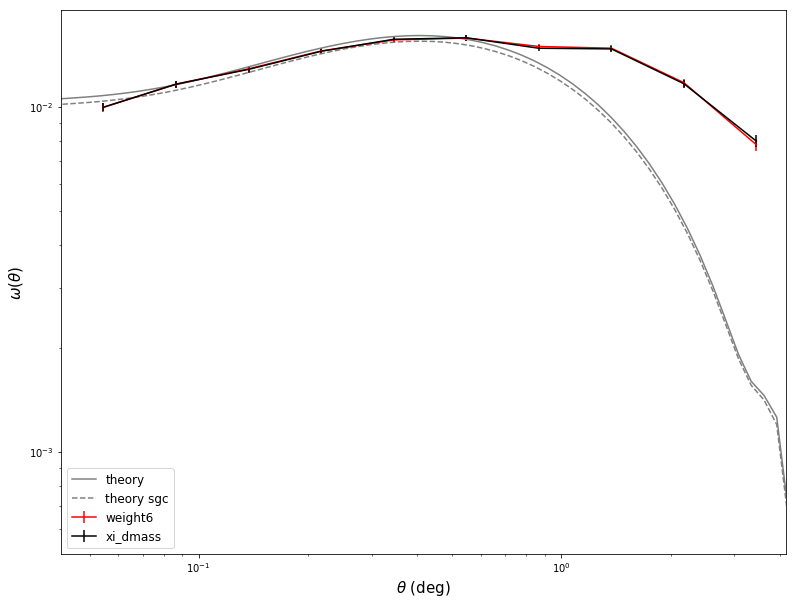

In [40]:
import scipy

theta_th, theory = np.loadtxt('../data_txt/acf_cmass_ngc_theory.txt', unpack=True)
theta_th, theory_sgc = np.loadtxt('../data_txt/acf_cmass_sgc_theory.txt', unpack=True)

#_, theory_bias = np.loadtxt('../data_txt/acf_cmass_sgc_theory_bias.txt', unpack=True)
#meanr, xi, xi_err = np.loadtxt(rootdir+'/act//acf_auto_gold_st82_nbins10_jk100.txt', unpack=True)
meanr, xi, xi_err = np.loadtxt(rootdir+'/act//acf_auto_poisson_DMASS_pcut_NOWEIGHT_10bins.txt', unpack=True)
meanr2, xi2, xi_err2 = np.loadtxt(rootdir+'/act//acf_auto_dmass_veto_pcut01_nbins10_jk100.txt', unpack=True)
meanr3, xi3, xi_err3 = np.loadtxt(rootdir+'/act//acf_auto_dmass_all_weight_pcut01_nbins10_jk100.txt', unpack=True)

theory_interp = scipy.interpolate.interp1d(theta_th, theory)
theory_interp = theory_interp(meanr)
theory_sgc_interp = scipy.interpolate.interp1d(theta_th, theory_sgc)
theory_sgc_interp = theory_sgc_interp(meanr)

nzs_ratio = theory_sgc_interp/theory_interp


meanr_sgc, xi_sgc, xi_err_sgc = np.loadtxt('../data_txt//acf_auto_cmass_sgc_sys_cp_nz_weight_nbins10_jk100.txt',unpack=True)
cov_cmass_s = np.genfromtxt('../data_txt//acf_auto_cmass_sgc_sys_cp_nz_weight_nbins10_jk100.cov')




fig, ax = plt.subplots(figsize = (13, 10))


ax.errorbar(meanr, meanr*xi, yerr = meanr*xi_err, fmt = '-', color='r', label='weight6')
ax.errorbar(meanr, meanr*xi_dmass, yerr = meanr*xi_err, fmt = '-', color='k', label='xi_dmass')
#ax.errorbar(meanr2, xi2, yerr = xi_err2, fmt = '-', color='b', label='dmass vetoed')
#ax.errorbar(meanr3, xi3, yerr = xi_err3, fmt = '-', color='g', label='dmass all weight')
#ax.errorbar(meanr_sgc, xi_sgc, yerr = xi_err_sgc, fmt = 'k.', color='r', label='cmass sgc')

ax.plot(theta_th, theta_th*theory, '-', color='grey', label='theory')
ax.plot(theta_th, theta_th*theory_sgc, '--', color='grey', label='theory sgc')
#ax.plot(theta_th, theta_th*theory_bias, '--', color='green', label='theory bias')

ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(loc = 'best', fontsize = 12)
#ax.text(1.5, 0.07, r'$\chi^2 $ = {:0.3f}  (south)'.format(chisqr), fontsize = 12)
#ax.set_ylim(1e-4,1)
ax.set_xlim(2.5/60, 250./60)
ax.set_xlabel(r'$\theta$ (deg)', fontsize = 15)
ax.set_ylabel(r'$\omega(\theta)$', fontsize = 15)

In [49]:
sys.path.append('/n/des/lee.5922/programs/cosmolike/MG_musigma/cosmolike_planck_working/')
from su_utils import read_cov, imshowplot


Nthetabin = 10
#cov_an_filename = '/n/des/lee.5922/programs/cosmolike/MG_musigma/cosmolike_planck_mg_deltab_gauss/cov/cov_mcal4_dmass_10bins'

cov_an_cmass_filename = '/n/des/lee.5922/programs/cosmolike/lighthouse_cov/output_cmass_sgc/cov_mcal4_cmass_sgc_veto_10bins_NG_llll_cov_Ntheta10_Ntomo4_1'
#cov_an_cmass_filename = '/n/des/lee.5922/programs/cosmolike/MG_musigma/cosmolike_planck_mg_deltab_gauss/cov/cov_mcal4_cmass_sgc_veto_10bins_NG'
cov_an_cmass_only_NG = read_cov( covfilename=cov_an_cmass_filename, G=False )[-10:, -10:]
cov_an_cmass_G = read_cov( covfilename=cov_an_cmass_filename, NG=False )[-10:, -10:]
cov_an_cmass_NG = cov_an_cmass_G + cov_an_cmass_only_NG

#cov_an_dmass_filename = '/n/des/lee.5922/programs/cosmolike/lighthouse_cov/output_dmass/cov_mcal4_dmass_pcut_sysweight_10bins_NG_llll_cov_Ntheta10_Ntomo4_1'
cov_an_dmass_filename = '/n/des/lee.5922/programs/cosmolike/lighthouse_cov/output_dmass/cov_mcal4_dmass_pcut_no_veto_10bins_NG_llll_cov_Ntheta10_Ntomo4_1'
#cov_an_dmass_filename = '/n/des/lee.5922/programs/cosmolike/MG_musigma/cosmolike_planck_mg_deltab_gauss/cov/cov_mcal4_dmass_pcut_sysweight_10bins_NG'
cov_an_dmass_G = read_cov( covfilename=cov_an_dmass_filename, NG = False )[-Nthetabin:, -Nthetabin:]
cov_an_dmass_only_NG = read_cov( covfilename=cov_an_dmass_filename, G=False )[-Nthetabin:, -Nthetabin:]
cov_an_dmass_NG = cov_an_dmass_G + cov_an_dmass_only_NG


#print cov_an.shape

In [50]:
def chisquare_calculation(xi1, xi2, F):
    
    diff = (xi1 - xi2)
    chi2 = np.dot(np.dot(diff, F), diff.T)
    
    return chi2

In [ ]:
cov_mocks = np.genfromtxt('../data_txt/mocks/cov_mock_galaxy_DR12_CMASS_S_QPM_760.cov')
#cov_mocks = np.genfromtxt('../data_txt/mocks/cov_mock_galaxy_DR12_CMASS_S_QPM_550_binslop05.cov')
#sigma_xi_sgc = np.sqrt(cov_mocks.diagonal()) 
cov_mocks_ngc = np.genfromtxt('../data_txt/mocks/cov_mock_galaxy_DR12_CMASS_N_QPM_1000.cov')
#sigma_xi_ngc = np.sqrt(cov_mocks_ngc.diagonal()) 

#cov_rescaled_mocks = np.genfromtxt('../data_txt/cmass/cov_rescaled_mocks_NG.txt')
cov_rescaled_mocks = np.genfromtxt('../data_txt/cmass/cov_dmass_no_veto_rescaled_mocks_NG.txt')
#sigma_xi_dmass = np.sqrt(cov_rescaled_mocks.diagonal()) 
#print cov_rescaled_mocks.shape

In [87]:
#meanr_sgc, xi_sgc, _ = np.loadtxt('../data_txt//acf_auto_cmass_sgc_sys_cp_nz_weight_nbins10_jk100.txt',unpack=True)
cmass_sgc_data = np.genfromtxt('../data_txt/cmass/npairs_cmass_sgc_bins10_binslop_05.txt')
_, meanr_sgc, _, xi_sgc, _, DD_sgc, RR_sgc, DR_sgc, npairs_sgc = [cmass_sgc_data[:,i] for i in range(9)]
cov_cmass_s = cov_mocks.copy() #cov_an_cmass.copy()
xi_err_sgc = np.sqrt(cov_cmass_s.diagonal())

cmass_ngc_data1 = np.genfromtxt('../data_txt/cmass/npairs_cmass_ngc_bins10_binslop_05.txt')
_, meanr_ngc, _, xi_ngc, sigma_xi_ngc1, DD_ngc, RR_ngc, DR_ngc, npairs_ngc = [cmass_ngc_data1[:,i] for i in range(9)]
#meanr_ngc, xi_ngc, _ = np.loadtxt('../data_txt//acf_auto_cmass_ngc_sys_cp_nz_weight_nbin10_jk100.txt',unpack=True)
cov_cmass_n = cov_mocks_ngc.copy() #np.genfromtxt('../data_txt//acf_auto_cmass_ngc_sys_cp_nz_weight_nbin10_jk100.cov')* 1./HFactor
xi_err_ngc = np.sqrt(cov_cmass_n.diagonal())


DD_full = DD_sgc + DD_ngc
DR_full = DR_sgc + DR_ngc
RR_full = RR_sgc + RR_ngc

meanr_full = meanr_ngc.copy()
xi_full = (DD_full - 2*DR_full + RR_full)*1./RR_full
cov_cmass_full = np.linalg.inv(np.linalg.inv( cov_cmass_s ) + np.linalg.inv( cov_cmass_s ))
xi_err_full = np.sqrt(cov_cmass_full.diagonal())

#dmass_data = np.genfromtxt('../data_txt/cmass/npairs_dmass_pcut_sysweight_bins10_binslop_05.txt')
#dmass_data = np.genfromtxt('../data_txt/cmass/npairs_dmass_pcut_veto_no_sysweight_10bins_binslop_05.txt')
#dmass_data = np.genfromtxt('../data_txt/cmass/npairs_dmass_pcut_no_veto_10bins_binslop_05.txt')
dmass_data = np.genfromtxt('../data_txt/cmass/npairs_dmass_pcut_no_veto_10bins_binslop_05_no3.txt')
_, meanr_dmass, _, xi_dmass, _, _, _, _, _ = [dmass_data[:,i] for i in range(9)]
cov_dmass = cov_rescaled_mocks.copy() #cov_an_dmass.copy()
xi_err_dmass = np.sqrt(cov_dmass.diagonal())


In [19]:
# callig cosmosis theory line

sis_dir = '/n/des/lee.5922/programs/cosmolike/cosmosis/output/'
xi_sgc_sis = np.genfromtxt(sis_dir + 'datav_cmass_sgc_theory/galaxy_xi_dmass/bin_1_1.txt')
xi_ngc_sis = np.genfromtxt(sis_dir + 'datav_cmass_ngc_theory/galaxy_xi_dmass/bin_1_1.txt')
xi_full_sis = np.genfromtxt(sis_dir + 'datav_cmass_full_theory/galaxy_xi_dmass/bin_1_1.txt')
theta_sis = np.genfromtxt(sis_dir + 'datav_cmass_sgc_theory/galaxy_xi_dmass/theta.txt')
theta_sis = theta_sis * 180/np.pi

In [20]:
sis_sgc_interp = scipy.interpolate.interp1d(theta_sis, xi_sgc_sis)
#sis_sgc_interp = sis_sgc_interp(meanr_sgc)

sis_full_interp = scipy.interpolate.interp1d(theta_sis, xi_full_sis)
#sis_full_interp = sis_full_interp(meanr_sgc)

sis_ngc_interp = scipy.interpolate.interp1d(theta_sis, xi_ngc_sis)
#sis_ngc_interp = sis_ngc_interp(meanr_sgc)

In [21]:
def chisquare(data1, data2, cov, ind = 0):
    diff = (data1 - data2)[ind:]
    F = np.linalg.inv(cov[ind:, ind:])
    chi2 = np.dot(diff, np.dot(F, diff))*1./diff.size
    return chi2

In [57]:
basedir

'../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//act/'

../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//act/acf_auto_poisson_DMASS_pcut_NOWEIGHT_10bins.npairs
err db, db / br1, brmin, br2 : 0.03714897818076557 -0.06079545814538134 0.9517673939752543 0.9704990333198354 0.9889163721560199
0.5136818835985826
../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//act/acf_auto_poisson_DMASS_pcut_VETO_10bins.npairs
err db, db / br1, brmin, br2 : 0.037131620511355434 -0.059745816927129436 0.9522296720170266 0.9709935971535254 0.989361292528382
0.5311722546434221
../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//act/acf_auto_poisson_DMASS_pcut_WEIGHT0_10bins.npairs
err db, db / br1, brmin, br2 : 0.03698920903584235 -0.07031500878897834 0.9473856173183021 0.966036565213277 0.9843748263541444
0.6065590165086735
../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5//act/acf_auto_poisson_DMASS_pcut_WEIGHT1_10bins.npairs
err db, db / br1, brmin, br2 : 0.03702288008663468 -0.0606204065028364 0.9518934920693852 0.97

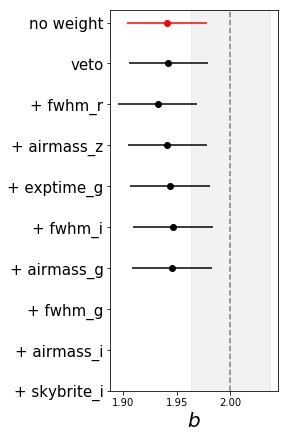

In [92]:
from systematics import brel_chisqr_fitting
import scipy


#theta_th, theory = np.loadtxt('../data_txt/acf_cmass_ngc_theory.txt', unpack=True)
#theta_th, theory_sgc = np.loadtxt('../data_txt/acf_cmass_sgc_theory.txt', unpack=True)
#theory_sgc_interp = scipy.interpolate.interp1d(theta_th, theory_sgc)
#theory_sgc_interp = theory_sgc_interp(meanr)

fig, ax = plt.subplots(figsize = (3,7))
brelsqr = np.linspace(0.5, 1.5, 5000) 
b_n = 2.0
brelarr = np.sqrt(brelsqr)
dbarray = b_n*(1-brelarr)


labels_SP = ['no weight', 'veto'] + ['+ '+o for o in order] #[1:] ]
#labels_SP = ['no weight'] + ['+ '+o for o in order]#[1:] ]


filenames = [ basedir+ 'acf_auto_poisson_DMASS_pcut_NOWEIGHT_10bins.npairs' \
              ,basedir + 'acf_auto_poisson_DMASS_pcut_VETO_10bins.npairs'
            ] \
+[ basedir+'acf_auto_poisson_DMASS_pcut_WEIGHT'+str(j)+'_10bins.npairs' for j in range(0, len(labels_SP)-2)]

#covnames = [ basedir+ 'acf_auto_dmass_no_weight_pcut01_nbins10_jk100.cov' \
#              ,basedir + 'acf_auto_dmass_veto_pcut01_nbins10_jk100.cov'
#           ] \
#+[ basedir+'acf_auto_dmass_weight'+str(j)+'_pcut01_nbins10_jk100.cov' for j in range(0, len(labels_SP)-2)]

F_d = np.linalg.inv(cov_rescaled_mocks)
F_d_an = np.linalg.inv(cov_an_dmass_NG)
F_ds = np.linalg.inv(cov_rescaled_mocks + cov_mocks)
F_ds_an = np.linalg.inv(cov_an_dmass_NG + cov_an_cmass_NG)
    

chisquare_list = []
chisquare_list_anlytic = []
chisquare_data_data_list = []
chisquare_data_data_an_list = []

delta_chi_list = []
delta_chi_list_analytic = []
for j in range(1, len(labels_SP)-2):
#for j in [1,7]:
    
    print filenames[j-1]
    #meanrw, xiw, xi_errw = np.loadtxt( filenames[j-1], unpack=True)
    _, meanrw, _, xiw, xi_errw, _, _, _,npairs = np.loadtxt( filenames[j-1], unpack=True)
    #cov_dmass_w = np.loadtxt( covnames[j-1], unpack=True)
    #cov_dmass_w = np.loadtxt( covnames[0], unpack=True)
    #meanrw, xiw, xi_errw = np.loadtxt(basedir+'acf_auto_dmass_weight'+str(j)+'_nbins10_jk100.txt', unpack=True)
    #cov_dmass_w = np.loadtxt(basedir+'acf_auto_dmass_weight'+str(j)+'_nbins10_jk100.cov', unpack=True)
    #HFd = HF(100, 10)
    #F_d = HFd * np.linalg.inv(cov_dmass_w)
    #F_s = np.linalg.inv(cov_cmass_s)
    err_brelw, brelw, chisqr_resultw = brel_chisqr_fitting(xiw, sis_sgc_interp(meanrw), F_d, verbose=True)
    #err_brelw, brelw, chisqr_resultw = brel_chisqr_fitting(xiw, xi_sgc, F_s, verbose=True)
    
    chi2 = chisquare_calculation(xiw, sis_sgc_interp(meanrw), F_d)
    chisquare_list.append( chi2/xiw.size )
    
    chi2_an = chisquare_calculation(xiw, sis_sgc_interp(meanrw), F_d_an)
    chisquare_list_anlytic.append( chi2_an/xiw.size )
    
    #chi2 = chisquare_calculation(xiw, xi_sgc, F_ds)
    chi2 = chisquare(xi_sgc, xiw, cov_mocks + cov_rescaled_mocks, ind=0)
    chisquare_data_data_list.append( chi2 )
    print chi2
    

    chi2 = chisquare(xi_sgc, xiw, cov_an_dmass_NG + cov_an_cmass_NG, ind=0)
    #chi2 = chisquare_calculation(xiw, xi_sgc, F_ds_an)
    chisquare_data_data_an_list.append( chi2 )
    
    if j < len(labels_SP) : 
        #meanrw2, xiw2, xi_errw2 = np.loadtxt( filenames[j], unpack=True)
        _, meanrw2, _, xiw2, xi_errw2, _, _, _,npairs = np.loadtxt( filenames[j], unpack=True)
        deltaw = xiw2-xiw
        delta_chi = np.dot(deltaw, np.dot( F_d/2., deltaw.T ))
        delta_chi_list.append(delta_chi)
        
        delta_chi_an = np.dot(deltaw, np.dot( F_d_an/2., deltaw.T ))
        delta_chi_list_analytic.append(delta_chi_an)
    
    if j == 1 : 
        color = 'red'
        ax.axvspan(2*1 - err_brelw*2., 2*1 + err_brelw*2.,  alpha=0.1, color='grey')
        ax.axvline(x=2, color = 'grey', ls='--')
        #ax.axvspan(- err_brelw*2.,  err_brelw*2.,  alpha=0.1, color='grey')
        #ax.axvline(x=0, color = 'grey', ls='--')
    else : color = 'k'  
        
    ax.errorbar(2*brelw, len(labels_SP)+1-j, xerr =err_brelw*2., fmt='-o', color=color)
    
#ax.set_xlabel(r'$\Delta b = b_{fid} - b_x$', fontsize = 20)
ax.set_xlabel(r'$b$', fontsize = 20)
#ax.set_ylabel(r'$\chi^2$')
ax.legend(loc=1)
#ax.set_xlim(1.96, 2.06)
#ax.set_yticks([1,2,3,4,5,6,7,8,9,10,11,12])
ax.set_yticks(np.arange(1, len(labels_SP)+1 ))

labels = labels_SP[::-1]
ax.set_yticklabels( labels, fontsize = 15) 
#fig.savefig(figoutdir + 'sys_bias_weight.png')
#print 'pic save to ', figoutdir + 'sys_bias_weight.png'






0.7721609241023436
0.7615414314105466
0.7606532147831833
0.8486739337140488
0.7369800740107658
0.8804042810215866
1.0356001986087837
0.8706193967808215
1.0823447014516274
1.3671828920308182


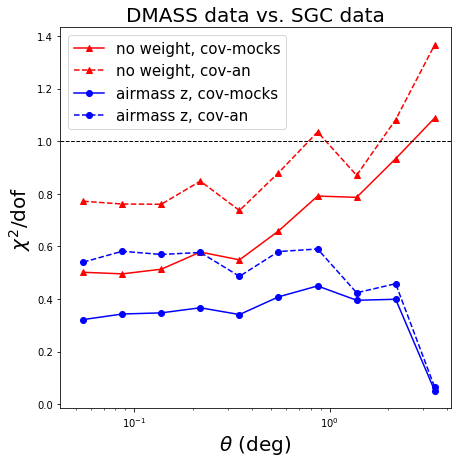

In [137]:
_, _, _, xi_dmass_az, _, _, _, _,npairs = np.loadtxt( filenames[5], unpack=True)


fig, ax = plt.subplots(figsize = (7,7))


chi_dmass_data_data_list = np.zeros(xi_sgc.size)
chi_dmass_data_data_an_list = np.zeros(xi_sgc.size)

chi_dmass_data_data_az_list = np.zeros(xi_sgc.size)
chi_dmass_data_data_az_an_list = np.zeros(xi_sgc.size)

for ind in range(0, 10):
    
    #chi_dmass_mocks_data_list[ind] = chisquare(xi_mocks_sgc, xi_dmass, cov_rescaled_mocks, ind=ind)
    #chi_dmass_mocks_data_an_list[ind] = chisquare(xi_mocks_sgc, xi_dmass, cov_an_dmass_NG, ind=ind)
    chi_dmass_data_data_list[ind] = chisquare(xi_sgc, xi_dmass, cov_mocks + cov_rescaled_mocks, ind=ind)
    chi_dmass_data_data_an_list[ind] = chisquare(xi_sgc, xi_dmass, cov_an_cmass_NG + cov_an_dmass_NG, ind=ind)
    
    chi_dmass_data_data_az_list[ind] = chisquare(xi_sgc, xi_dmass_az, cov_mocks + cov_rescaled_mocks, ind=ind)
    chi_dmass_data_data_az_an_list[ind] = chisquare(xi_sgc, xi_dmass_az, cov_an_cmass_NG + cov_an_dmass_NG, ind=ind)
    
    #chi_dmass_theory_data_list[ind] = chisquare(sis_sgc_interp, xi_dmass, cov_rescaled_mocks, ind=ind)
    #chi_dmass_theory_data_an_list[ind] = chisquare(sis_sagc_interp, xi_dmass, cov_an_dmass_NG, ind=ind)
    print chi_dmass_data_data_an_list[ind]
    
#ax.plot(theta_sgc, chi_dmass_mocks_data_list, 'bo-', label='mock-data, cov-mocks')
#ax.plot(theta_sgc, chi_dmass_mocks_data_an_list, 'bo--', label='mock-data, cov-an')
ax.plot(meanr_sgc, chi_dmass_data_data_list, 'r^-', label='no weight, cov-mocks')
ax.plot(meanr_sgc, chi_dmass_data_data_an_list, 'r^--', label='no weight, cov-an')

ax.plot(meanr_sgc, chi_dmass_data_data_az_list, 'bo-', label='airmass z, cov-mocks')
ax.plot(meanr_sgc, chi_dmass_data_data_az_an_list, 'bo--', label='airmass z, cov-an')

#ax.plot(theta_sgc, chi_dmass_theory_data_list, 'ks-', label='data-theory, cov-mocks')
#ax.plot(theta_sgc, chi_dmass_theory_data_an_list, 'ks--', label='data-theory, cov-an')
ax.set_xscale('log')
ax.set_xlim(2.5/60, 250/60.)
#ax.set_ylim(0, 4)
ax.axhline(y = 1.0, ls='--', color='k', lw=1)

ax.legend(loc='best', fontsize=15)
ax.set_xlabel('$\\theta$ (deg)', fontsize = 20)
ax.set_ylabel(r'$\chi^2/{\rm dof}$', fontsize = 20)

ax.set_title('DMASS data vs. SGC data', fontsize=20)

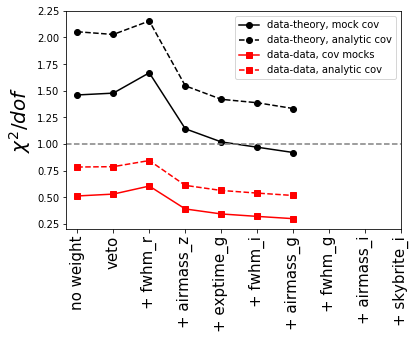

In [97]:
fig, ax = plt.subplots()

ax.plot( np.arange(len(chisquare_list)), chisquare_list, 'ko-', label='data-theory, mock cov' )
ax.plot( np.arange(len(chisquare_list)), chisquare_list_anlytic, 'ko--', label='data-theory, analytic cov' )
ax.plot( np.arange(len(chisquare_list)), chisquare_data_data_list, 'rs-', label='data-data, cov mocks' )
ax.plot( np.arange(len(chisquare_list)), chisquare_data_data_an_list, 'rs--', label='data-data, analytic cov' )

#ax.set_xlabel(r'$\Delta b = b_{fid} - b_x$', fontsize = 20)
ax.set_ylabel(r'$\chi^2/ dof$', fontsize = 20)
#ax.set_ylabel(r'$\chi^2$')
#ax.legend(loc=1)
#ax.set_xlim(1.96, 2.06)
#ax.set_yticks([1,2,3,4,5,6,7,8,9,10,11,12])
ax.set_xticks(np.arange(0, len(labels_SP) ))
ax.axhline(y=1.0, color='grey', ls='--')

labels = labels_SP
ax.set_xticklabels( labels, fontsize = 15, rotation=90) 

ax.legend()



In [90]:
chisquare_data_data_an_list

[0.7850340745698972,
 0.7884390501875588,
 0.8459772881618424,
 0.6129550005645541,
 0.5653033440598881,
 0.540526041822423,
 0.5181774814747364]

In [39]:
labels_SP[2].split('+')[0]

''

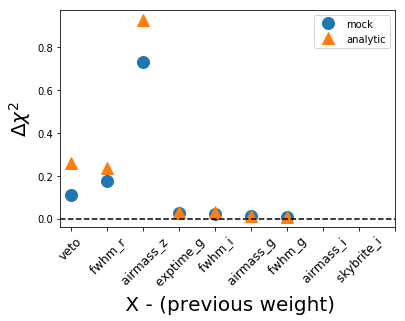

In [128]:
fig, ax = plt.subplots()

delta_chisquare_list = np.array(chisquare_list[:-1]) - np.array(chisquare_list[1:]) 
delta_chisquare_list_an = np.array(chisquare_list_anlytic[:-1]) - np.array(chisquare_list_anlytic[1:]) 
#ax.plot( np.arange(9), delta_chisquare_list, label='mock' )
#ax.plot( np.arange(9), delta_chisquare_list_an, label='analytic' )
ax.plot( np.arange(len(delta_chi_list)), delta_chi_list, 'o' , markersize = 12, label='mock' )
ax.plot( np.arange(len(delta_chi_list)), delta_chi_list_analytic, '^', markersize = 12, label='analytic' )
ax.legend()

#ax.set_xlabel(r'$\Delta b = b_{fid} - b_x$', fontsize = 20)
ax.set_ylabel(r'$\Delta \chi^2$', fontsize = 20)
ax.axhline(y=0, color='k', ls='--')
#ax.set_ylabel(r'$\chi^2$')
#ax.legend(loc=1)
#ax.set_xlim(1.96, 2.06)
#ax.set_yticks([1,2,3,4,5,6,7,8,9,10,11,12])
ax.set_xticks(np.arange(0, len(labels_SP) ))

#labels = [ labels_SP[i+1].split('+')[-1] + ' - ' + labels_SP[i].split('+')[-1] for i in range(len(labels_SP)-1) ]
labels = [ labels_SP[i+1].split('+')[-1] for i in range(len(labels_SP)-1) ]
ax.set_xticklabels( labels, fontsize = 12, rotation=45) 
ax.set_xlabel(' X - (previous weight)', fontsize = 20)

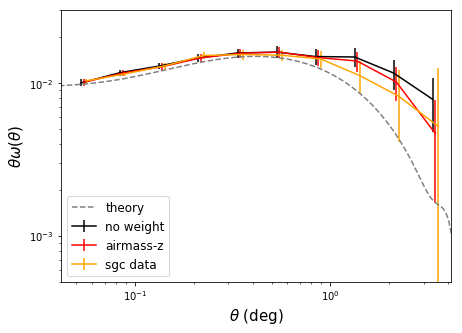

In [150]:
import scipy

_, _, _, xi_dmass_no_weight, _, _, _, _,npairs = np.loadtxt( filenames[0], unpack=True)
_, _, _, xi_dmass_az, _, _, _, _,npairs = np.loadtxt( filenames[5], unpack=True)




fig, ax = plt.subplots(figsize = (7, 5))


ax.errorbar(meanr_dmass*0.97, meanr_dmass* xi_dmass_no_weight, yerr = meanr_dmass* xi_err_dmass, fmt = '-', color='k', label='no weight')
ax.errorbar(meanr_dmass, meanr_dmass*xi_dmass_az, yerr = meanr_dmass * xi_err_dmass, fmt = '-', color='r', label='airmass-z')
ax.errorbar(meanr_sgc*1.03, meanr_sgc*xi_sgc, yerr = meanr_sgc*xi_err_sgc, fmt = '-', color='orange', label='sgc data')
#ax.errorbar(meanr3, xi3, yerr = xi_err3, fmt = '-', color='g', label='dmass all weight')
#ax.errorbar(meanr_sgc, xi_sgc, yerr = xi_err_sgc, fmt = 'k.', color='r', label='cmass sgc')

ax.plot(theta_sis, theta_sis * xi_sgc_sis, '--', color='grey', label='theory')
#ax.plot(theta_th, theta_th*theory_bias, '--', color='green', label='theory bias')

ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(loc = 'best', fontsize = 12)
#ax.text(1.5, 0.07, r'$\chi^2 $ = {:0.3f}  (south)'.format(chisqr), fontsize = 12)
ax.set_ylim(5e-4,0.03)
ax.set_xlim(2.5/60, 250./60)
ax.set_xlabel(r'$\theta$ (deg)', fontsize = 15)
ax.set_ylabel(r'$\theta \omega(\theta)$', fontsize = 15)